In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/BCH.zip

Streaming output truncated to the last 5000 lines.
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2401_class0.png  
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1101_class0.png  
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1151_class0.png  
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1201_class0.png  
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1251_class0.png  
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1301_class0.png  
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1351_class0.png  
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1401_class0.png  
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1451_class0.png  
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1501_class0.png  
 extracting: BCH/BCH/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2401_y1551_class0.png  
 extracting: B

In [3]:
import numpy as np 
import pandas as pd 
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image

In [4]:
from glob import glob
data = glob('/content/BCH/**/*.png', recursive=True)

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

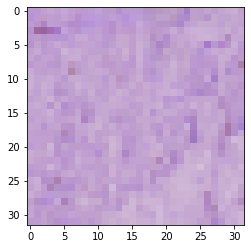

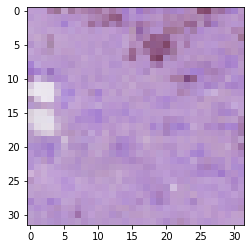

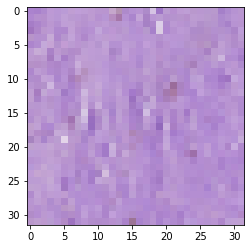

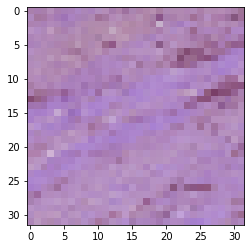

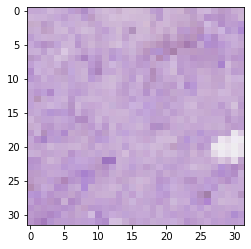

In [6]:
import cv2
import matplotlib.pyplot as plt
for i in data[:5]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(32,32))
    plt.imshow(img_1,cmap='binary')
    plt.show()

In [7]:
images=[]
labels=[]
for i in data[:15000]:
    if i.endswith('.png'):
        label=i[-5]
        img=cv2.imread(i)
        img_1=cv2.resize(img,(32,32))
        images.append(img_1)
        labels.append(label)

In [33]:
labels[1000]

'1'

In [41]:
len(labels)

15000

In [89]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=None,test_size=0.2)

In [90]:
y_train=[]
for i in range(12000):

  y_train.append(int(labels[i]))


In [91]:
y_train=np.array(y_train)

In [92]:
y_train.shape

(12000,)

In [93]:
y_train=y_train.reshape(12000,1)

In [94]:
y_train.shape

(12000, 1)

In [95]:
y_test=[]
for i in range(12000,15000):

  y_test.append(int(labels[i]))

In [96]:
y_test=np.array(y_test)
y_test.shape

(3000,)

In [97]:
y_test=y_test.reshape(3000,1)
y_test.shape

(3000, 1)

In [98]:
x=np.stack(images)

In [99]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(labels)

In [100]:
#normalize the data
x=x/255

In [101]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
num_classes = 2
input_shape = (32, 32, 3)

In [103]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (12000, 32, 32, 3) - y_train shape: (12000, 1)
x_test shape: (3000, 32, 32, 3) - y_test shape: (3000, 1)


In [104]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 20
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [105]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [106]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [107]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


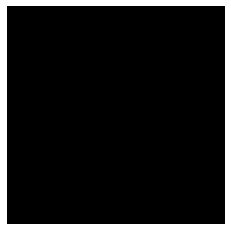

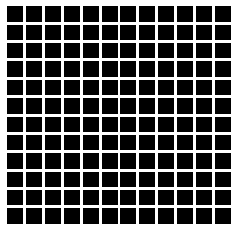

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [109]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [110]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [111]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)

    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/20
43/43 [==============================] - 33s 555ms/step - loss: 1.3593 - accuracy: 0.5557 - top-5-accuracy: 1.0000 - val_loss: 0.7530 - val_accuracy: 0.3383 - val_top-5-accuracy: 1.0000
Epoch 2/20
43/43 [==============================] - 20s 467ms/step - loss: 0.6862 - accuracy: 0.6028 - top-5-accuracy: 1.0000 - val_loss: 0.7536 - val_accuracy: 0.3383 - val_top-5-accuracy: 1.0000
Epoch 3/20
43/43 [==============================] - 22s 503ms/step - loss: 0.6741 - accuracy: 0.6122 - top-5-accuracy: 1.0000 - val_loss: 0.7541 - val_accuracy: 0.3383 - val_top-5-accuracy: 1.0000
Epoch 4/20
43/43 [==============================] - 20s 460ms/step - loss: 0.6701 - accuracy: 0.6226 - top-5-accuracy: 1.0000 - val_loss: 0.7513 - val_accuracy: 0.3383 - val_top-5-accuracy: 1.0000
Epoch 5/20
43/43 [==============================] - 21s 487ms/step - loss: 0.6697 - accuracy: 0.6212 - top-5-accuracy: 1.0000 - val_loss: 0.7669 - val_accuracy: 0.3383 - val_top-5-accuracy: 1.0000
Epoch 6/20
43/4